# Identifying SAT Exam Bias in NYC High Shools

In this project we're going to try to determine whether the SAT is a fair test for different demographic groups. We're going to work on data from NYC, which is very diverse and has a significant immigrant population.

We're going to compare demographic factors like: 
- race
- income
- gender

with SAT scores and identify whether certain demographic groups perform better than others.

### Summary of results

- There is a positive correlation between SAT scores and percentage of white and asian students, and negative correlation with percentage of black and hispanic students. Apart from racial bias, other potential explanations might include low funding of schools and high percentage of English-learning students, so it should be investigated further.

- Schools located in high-income areas of New York tend to have a higher average SAT score.

- There is no correlation between SAT score and gender.

### Data dictionary
During the analysis, we're going to combine the following datasets into a single, clean pandas dataframe: 
- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4/about_data) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt/about_data) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3/about_data) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e/about_data) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a/about_data) - The percentage of students who graduated and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j/about_data) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8/about_data) - Surveys of parents, teachers, and students at each school

## 1: Data cleaning
### Reading in and exploring datasets
As out ultimate goal is to merge the dataframes, we need to perform initial analysis on the individual datasets. We'll read each file into a pandas dataframe and then store all of the dataframes in a dictionary for easier storage and referencing.

`survey_all.txt` and `survey_d75.txt` are in more complicated formats than the other files. For now, we'll focus on reading in the CSV files only, and then explore them.

In [57]:
# importing libraries using their common aliases
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns

# recording all file names into a list
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# creating an empty dictionary to store dataframes in
data = {}

#reading in the files and standardizing naming
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

Now each key in data should have the corresponding dataframe as its value.

We're now going to explroe the `SAT dataset`, which corresponds to the dictionary key `sat_results`. This dataset contains the SAT scores for each high school in New York City. We eventually want to correlate selected information from this dataset with information in the other datasets.

In [2]:
print(data['sat_results'].head(5))

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

We can make a few observations based on this output:

- The `DBN` appears to be a unique ID for each school.
- We can tell from the first few rows of names that we only have data about high schools.
- There's only a single row for each high school, so each DBN is unique in the SAT data.
- We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.

Let's explore the other datasets to see if we can gain any insight into how to combine them.

In [3]:
for key in data:
    print(data[key].head(5))

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

We can make some observations based on the first few rows of each one.

- Each dataset appears to either have a DBN column or the information we need to create one. That means we can use a DBN column to combine the datasets. 
- The field called `Location 1` is useful for mapping, because it contains coordinates inside a larger string
- Some of the datasets appear to contain multiple rows for each school (because the rows have duplicate DBN values)

We can now move on to the survey data.

In [4]:
# reading in the surveys individually
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
# combining into one dataframe
survey = pd.concat([all_survey, d75_survey], axis=0)

print(survey.head())

      dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p  ...  s_q14_2  \
0         0.0           Elementary School   NaN    88    60  ...      NaN   
1         0.0           Elementary School   NaN   100    60  ...      NaN   
2         0.0           Elementary School   NaN    88    73  ...      NaN   
3         0.0  Elementary / Middle School  89.0    73    50  ...      NaN   
4         0.0           Elementary School   NaN   100    60  ...      NaN   

   s_q14_3  s_q14_4  s_q14_5  s_q14_6  s_q14_7  s_q14_8  s_q14_9  s_q14_10  \
0      NaN      NaN 

### Filtering and maintaining consistency
There are two immediate facts that we can see in the data:
- There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones.
- The survey data has a `dbn` column that we'll want to convert to uppercase (DBN) for consistency

In [5]:
# converting column name to upper case
survey["DBN"] = survey["dbn"]

# filtering mecessaru data
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey.loc[:,survey_fields]

# assigning the dataframe survey to the key survey in the dictionary data.
data["survey"] = survey
print(survey.head())

      DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0  01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6       7.5   
1  01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6       7.6   
2  01M020   NaN    88    73    NaN  42.0  367.0       8.9       8.3       8.3   
3  01M034  89.0    73    50  145.0  29.0  151.0       8.8       8.2       8.0   
4  01M063   NaN   100    60    NaN  23.0   90.0       8.7       7.9       8.1   

   ...  eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0  ...       7.6       7.9       NaN       NaN       NaN       NaN   
1  ...       8.9       9.1       NaN       NaN       NaN       NaN   
2  ...       6.8       7.5       NaN       NaN       NaN       NaN   
3  ...       6.8       7.8       6.2       5.9       6.5       7.4   
4  ...       7.8       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11  
0         8.0         7.7         7.5   

### Adding the 'DBN' column
When we explored all of the datasets, we noticed that `class_size` doesn't have a `dbn` column while `hs_directory` does have one, but it needs to be renamed.

Looking at the `sat_results` data at the top, we can tell that the `DBN` in the sat_results data is just a combination of the `CSD` and `SCHOOL CODE` columns in the `class_size` data.

Because the `DBN` is padded, we'll need to add a leading 0 to the `CSD` if the `CSD` is less than two digits long.

In [6]:
# adding DBN columns
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# creating the function to make csd padded
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
# apply the function to make csd padded    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
# adding the DBN column by combining padded csd and school code
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
print(data['class_size']['DBN'].head(5))

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object


### Combining the SAT scores
As we've mentioned before, it'd be great to combine all SAT score-related columns into one. Before we do that, we will convert all values to a numeric data type.

In [7]:
# converting columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
print(data['sat_results']['sat_score'].head(5))

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


### Parsing Geographic Coordinates for Schools
Next, we'll want to parse the latitude and longitude coordinates to map the schools and uncover any geographic patterns in the data. 

In [8]:
# creating a function that extracts the lattitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# creating a function that extracts the longitude
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# applying the functions to columns in hs_directory
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# converting values to numeric data type
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

print(data['hs_directory'].head(5))

      dbn                                        school_name       boro  \
0  17K548                Brooklyn School for Music & Theatre   Brooklyn   
1  09X543                   High School for Violin and Dance      Bronx   
2  09X327        Comprehensive Model School Project M.S. 327      Bronx   
3  02M280     Manhattan Early College School for Advertising  Manhattan   
4  28Q680  Queens Gateway to Health Sciences Secondary Sc...     Queens   

  building_code    phone_number    fax_number grade_span_min  grade_span_max  \
0          K440    718-230-6250  718-230-6262              9              12   
1          X400    718-842-0687  718-589-9849              9              12   
2          X240    718-294-8111  718-294-8109              6              12   
3          M520  718-935-3477             NaN              9              10   
4          Q695    718-969-3155  718-969-3552              6              12   

  expgrade_span_min  expgrade_span_max  ...                       pr

### Condense datasets: Class size
The first thing we'll need to do in preparation for the merge is condense some of the datasets to make sure each value is unique. In the last lesson, we noticed that the values in the `DBN` column were unique in the `sat_results` data set. Other data sets like `class_size` had duplicate DBN values.

In `class_size`, we're only concerned with grades 9 through 12, so we'll pick rows where the value in the `GRADE` column is `09-12`.

Each school can have multiple program types. Since `GEN ED` is the largest category by far, let's only select rows where `PROGRAM TYPE` is `GEN ED`.

In [9]:
# filtering necessary grade and program type data
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

print(class_size.head(5))

     CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -  

### Computing Average Class Sizes

We will compute average class sizes to account for variations in class sizes across different subjects and courses offered by schools. 

In [10]:
# grouping columns according to dbn and finding a mean
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
# assigning values to the class_size dataset
data["class_size"] = class_size

print(data['class_size'].head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

### Condensing datasets: Demographics
Now that we've finished condensing `class_size`, let's condense `demographics`. 

The only column that prevents a given `DBN` from being unique is `schoolyear`. We only want to select rows where `schoolyear` is `20112012`. This will give us the most recent year of data, and also match our SAT results data.

In [11]:
# filtering desired years
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
print(data['demographics'].head(5))

       DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  ...  \
6         NaN         89.4               189   13   31     35     28  ...   
13        NaN         61.5               328   32   46     52     54  ...   
20        NaN         92.5               626   52  102    121     87  ...   
27        NaN         99.7               401   14   34     38     36  ...   
35        NaN         78.9               176   18   20     30     21  ...   

   black_num black_per hispanic_num hispanic_per white_num white_per male_num  \

### Condensing datasets: Graduation

The `Demographic` and `Cohort` columns are what prevent `DBN` from being unique in the graduation data.

We want to pick data from the most recent `Cohort` available, which is `2006`. We also want data from the full cohort, so we'll only pick rows where `Demographic` is Total Cohort.

In [12]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
print(data['graduation'].head(5))

     Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
3             78              43                     55.1%                36   
10           124              53                     42.7%                42   
17            90              70                     77.8%                67   
24            84              47                       56%                40   
31           193             105                     54.4%                91   

   Total Regents - % of cohort Total Regents - % of grads  ...  \
3       

### Convert AP scores to numeric
To find out whether AP exam scores are correlated with SAT scores across high schools, we'll need to convert the AP exam scores in the `ap_2010` data set to numeric values first.

In [13]:
# creating the list with column names
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

#converting each column from the list to numeric data type
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

print(data['ap_2010'].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


### Performing the left joins
Both the `ap_201`0 and the `graduation` datasets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them.

Our final dataframe will have all of the same DBN values as the original `sat_results` dataframe.

In [14]:
# combining the datasets
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

print(combined.head(5))
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3                401.0      

### Performing the inner joins 
Since `class_size`, `demographics`, `survey`, and `hs_directory` files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.

In [15]:
# merging datasets one by one
combined = combined.merge(data['class_size'], how='inner', on='DBN')
combined = combined.merge(data['demographics'], how='inner', on='DBN')
combined = combined.merge(data['survey'], how='inner', on='DBN')
combined = combined.merge(data['hs_directory'], how='inner', on='DBN')

print(combined.head(5))
print(combined.shape)

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

### Filling in missing values
Because we used left joins previously, we now have many columns with null values. To tackle this, we'll fill in the missing values with the overall mean for the column.

If there are any NaN or null values that remain after the initial replacement, we will replace them with the value 0.

In [16]:
# replacing missing values with the mean or 0
combined_means = combined.mean()
combined = combined.fillna(combined_means)
combined = combined.fillna(0)
print(combined[:2])

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   

                     SchoolName  AP Test Takers   Total Exams Taken  ...  \
0                             0       129.028846         197.038462  ...   
1  UNIVERSITY NEIGHBORHOOD H.S.        39.000000          49.000000  ...   

                                priority04                       priority05  \
0  Then to Manhattan students or residents  Then to New York City residents   
1                                        0                      

### Adding a school district column for mapping
To map the statistics out on a school district level, we'll add a column that specifies the school district using the first two charactes of the `DBN`.

In [17]:
# extracting the first 2 characters from DBN
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

print(combined['school_dist'].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


## 2: Data analysis 
### Finding correlations with the r value
At first we'll discover correlations between SAT score and demographics.

In [58]:
#finding correlations related to the SAT score
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Apart from all SAT score-related columns having a strong correlation with the SAT score, we can make some other observations: 
- `total_enrollment` has a strong positive correlation with `sat_score`. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
    - Other columns that are proxies for enrollment correlate similarly. These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.
- Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate positively with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate negatively. This could indicate that women do better on the SAT than men.
- Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
- Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).
- There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).
- The percentage of students eligible for free or reduced school lunch based on household income (`frl_percent`) has a strong negative correlation with SAT scores.

### Plotting enrollment 
As mentioned, we'd like to explore whether a high total enrollment really correlates with a high SAT score.

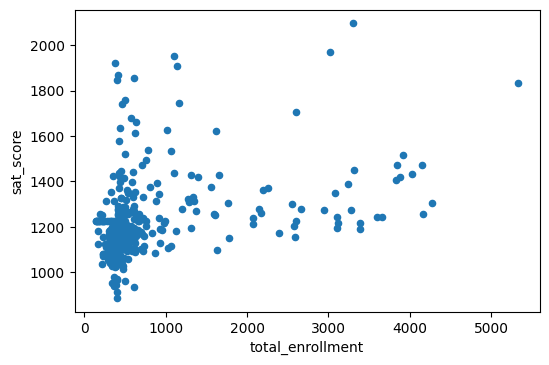

In [19]:
# building a scatter plot
combined.plot.scatter('total_enrollment', 'sat_score')
plt.show()

There is a weak positive correlation between the factors. As we notice, schools with the lowest SAT score tend to have a low total enrollment. There are also many examples of schools with high enrollment and high SAT score. 

Based on the [paper from Columbia University](https://ncspe.tc.columbia.edu/working-papers/files/OP35V2.pdf), high competition provides positive educational outcomes.

### Exploring class size and SAT scores
As mentioned before, there is a slight positive correlation between `total_enrollment` and `sat_score`. We can assume positive correlation of SAT score with an average class size as it would be inconvenient to teach many studens in small groups. Let's support our assumption with data.

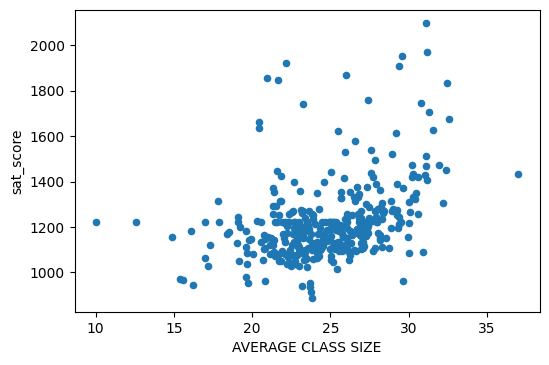

In [59]:
# building a scatter plot of SAT score and class size
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')

There is a slight upward trend between the average class size and SAT score. Most schools with a high SAT score have around 20-30 students in a class.

### Exploring schools with low SAT scores and enrollment

There's an interesting cluster of points at the bottom left where `total_enrollment` and `sat_score` are both low. We'll extract the names of the schools in the cluster and research them further.

In [20]:
# filtering schools with a low total enrollment and sat score
low_enrollment = combined[combined['total_enrollment'] < 1000]
low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000]
print(low_enrollment['School Name'])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


Most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners.
### Plotting language learning percentage
The previous graph might indicate that it's actually `ell_percent` that correlates strongly with `sat_score`. 

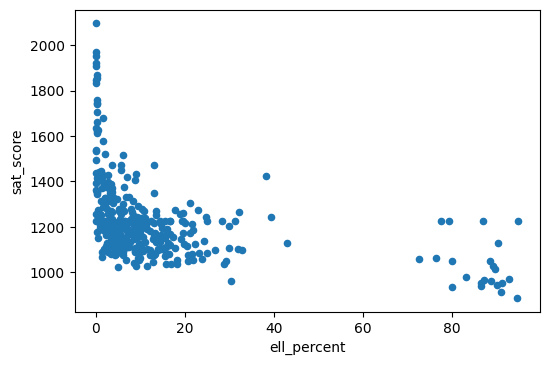

In [21]:
combined.plot.scatter('ell_percent', 'sat_score')
plt.show()

The schools that have the highest SAT scores also have lowest percentage of English language learners. The schools with the highest percentage of English language learners tend to have a lower SAT score. 
### Plotting survey correlations
Now we're going to explore correlations between [survey resuts of parents, teachers and students](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8/about_data). The data dictionary can be found via the link to the dataset.

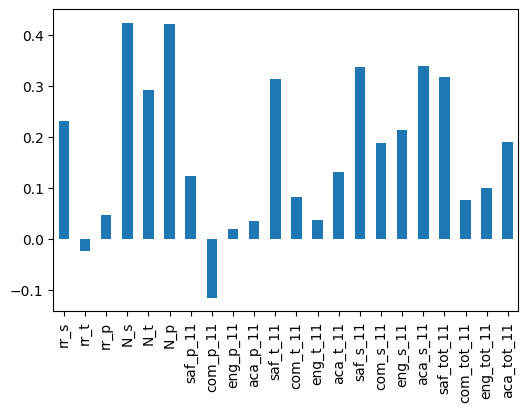

In [23]:
# Removing DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# displaying the list of correlations between SAT score and different survey fields
combined.corr()["sat_score"][survey_fields].plot.bar()

We can see strong positive correlations of SAT score with:
- `N_s`: Number of student respondents
- `N_t`: Number of teacher respondents
- `N_p`: Number of parent respondents
It makes sense because all of these columns also correlate with `total_enrollment`. Schools with higher total enrollment tend to have more resources, including better facilities, more experienced teachers, and a wider range of academic offerings.

Next, there are positive correlations of SAT score with: 
- `saf_t_11`: Safety and Respect score based on teacher responses
- `saf_s_11`: Safety and Respect score based on student responses
- `saf_tot_11`: Safety and Respect total score
It also makes sense because it's hard to teach and learn in an unsafe environment.

Finally, there's an interesting observation. SAT score correlates positively with:
- `aca_s_11`: Academic expectations score based on student responses
- `aca_tot_11`: Academic Expectations total score
But not with `aca_p_11` and `aca_t_11`, academic expectations of parents and teachers. 

Students with high academic expectations are more likely to actively engage in learning, seek resources, and ask questions, leading to improved academic performance, including higher SAT scores. Teachers and parents may have different perspectives on students' academic abilities and potential compared to the students themselves.

### Exploring Safety and SAT Scores
Next, we'll dig into the relationship between safety and SAT scores a bit more. We'll try to figure out which schools have low safety scores.

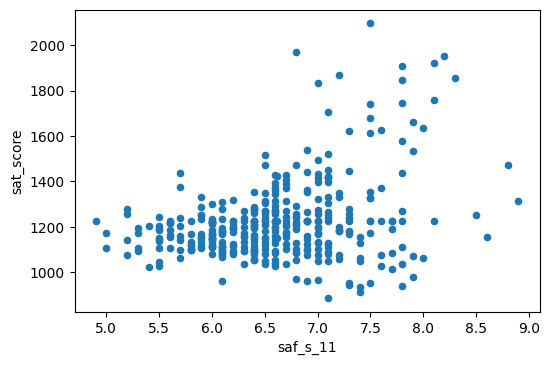

In [24]:
combined.plot.scatter('saf_s_11', 'sat_score')

Although it isn't a very strong correlation, we can see a trend that schools with a high safety score also have a high average SAT score. Also, almost all schools with a safety score below 6.5 don't reach an average SAT score higher than 1600.

### Exploring school safety scores by borough
We're now going to explore average school safety scores in different boroughs of New York.

In [32]:
# grouping boroughs by the mean safety score
boros = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
# displaying in the descending order
boros.sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

Manhattan (6.831), renowned for its luxurious and prestigious schools, scored the highest, while Brooklyn (6.371) scored lower, reflecting potential school safety concerns attributed to its dynamic nightlife. Queens, Bronx, and Staten Island scored in between.

This data confirms that students who go to schools in safer neighbourhoods, which also tend to be high-income areas of NY, tend to have higher SAT scores.

### Exploring Race and SAT Scores
We're going to plot out the correlations between the SAT score and columns that indicate the percentage of each race at a given school. That way we'll determine whether there are any racial differences in SAT performance.

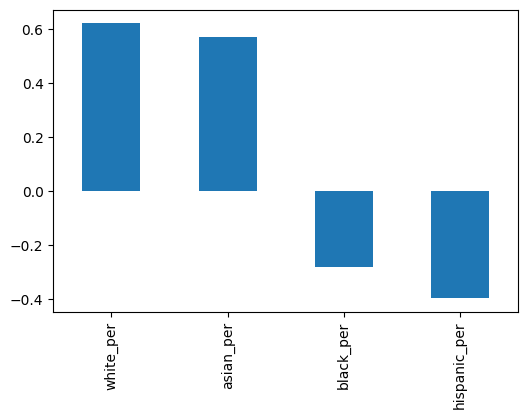

In [35]:
# specifying race-related fields
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
# representing correlations as bar plots
combined.corr()['sat_score'][race_fields].plot.bar()

A school's higher percentage of white or Asian students tends to correlate positively with SAT scores, while a higher percentage of black or Hispanic students correlates negatively. The negative correlation can be explained to disparities in funding, particularly in areas with more black or Hispanic students.

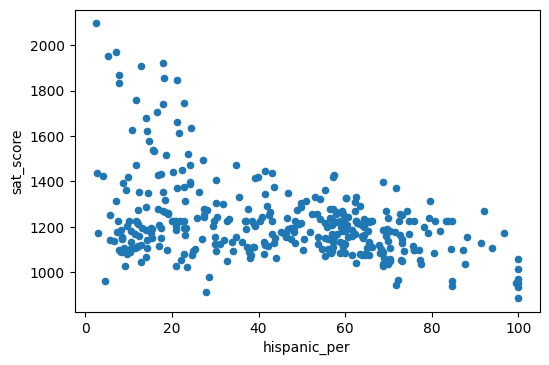

In [36]:
# building a scatter plot of SAT score and percentage of Hispanic students
combined.plot.scatter('hispanic_per', 'sat_score')

The scatter plot confirms the negative correlation.

In [42]:
# displaying names of schools with high percentage of hispanic students
combined[combined['hispanic_per'] > 95]['SCHOOL NAME'].head(7)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Researching about schools from the list, like [Multicultural High School](https://insideschools.org/school/19K583) or [Manhattan Bridges High School](https://insideschools.org/school/02M542), shows that these schools cater for immigrants who recently arrived from Spanish-speaking countries. These schools have many students who are learning English, which would explain the lower SAT scores.

In [43]:
# displaying names of schools with low percentage of hispanic students 
combined[combined['hispanic_per'] <10]['SCHOOL NAME'].head(7)

37                              STUYVESANT HIGH SCHOOL
46     HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                       BRONX HIGH SCHOOL OF SCIENCE
187                     BROOKLYN TECHNICAL HIGH SCHOOL
192                        BEDFORD ACADEMY HIGH SCHOOL
194                          BENJAMIN BANNEKER ACADEMY
220                         BOYS AND GIRLS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Again, doing a quick research on the schools from the list, like [Stuyvesant High School](https://en.wikipedia.org/wiki/Stuyvesant_High_School) or [Bronx Science](https://en.wikipedia.org/wiki/Bronx_High_School_of_Science), we notice that these schools are highly selective and require to pass the standardized test on admissions. It does explain the high SAT score as students from this school are well-prepared for similar examinations. However, it doesn't explain the low percentage of Hispanic students.

### Exploring gender and SAT scores
Next, we're going to plot out the correlations between the percentage of each gender and SAT score.

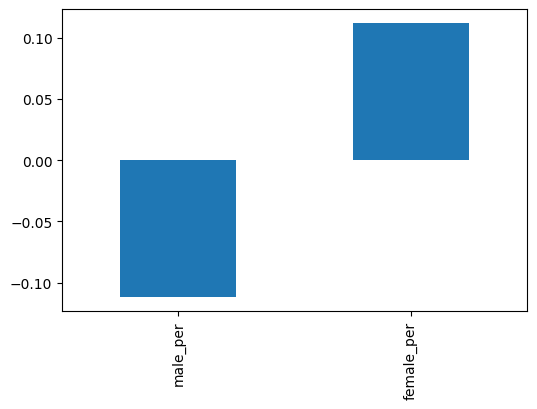

In [45]:
# specifying gender-related columns
gender_cols = ['male_per', 'female_per']
# representing correlations as bar plots
combined.corr()['sat_score'][gender_cols].plot.bar()

Interestingly, schools with high percentage of female students tend to have a higher average SAT score. The trend is the opposite with the high percentage of male students. 

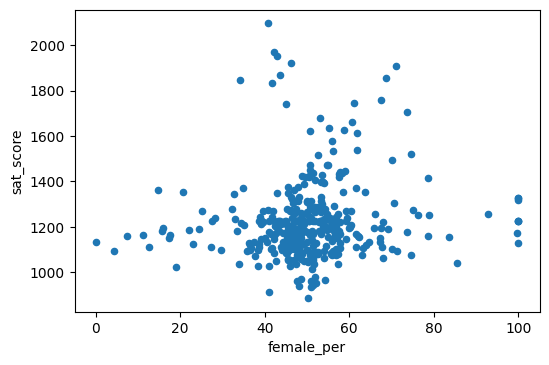

In [46]:
# building a scatter plot of SAT score and percentage of female students
combined.plot.scatter('female_per', 'sat_score')

Based on the scatter plot, there's no real correlation between gender and SAT score. There is, however, a cluster of schools with high percentage of females (60-80%) and a high SAT score.

In [49]:
# displaying names of schools with high percentage of female students and high SAT score
combined[(combined['female_per'] >60) & (combined['sat_score']>1700)]['SCHOOL NAME'].head(7)

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Researching individual schools from the list, such as [Bard High School Early College](https://en.wikipedia.org/wiki/Bard_High_School_Early_College) or [Eleanor Roosevent High School](https://en.wikipedia.org/wiki/Eleanor_Roosevelt_High_School_(New_York_City)), we can see that these schools also have a very strict admissions process and high academic standards.

### Exploring AP scores and SAT scores
[Advanced Placement (AP)](https://en.wikipedia.org/wiki/Advanced_Placement_exams) exam is an exam that high school students take to earn college credit in the US. It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores.

To avoid bias from `total_enrollment`, we'll explore the correlation between SAT score and the percentage of students in each school who took at least one AP exam.

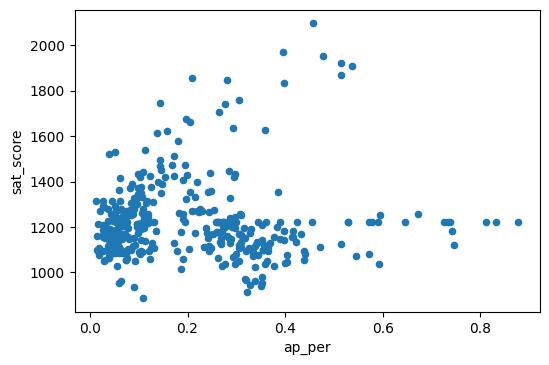

In [51]:
# calculating percentage of students who took an AP exam
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
# building a scatter plot of SAT score and AP score
combined.plot.scatter('ap_per', 'sat_score')

There is a weak positive correlation between the percentage of AP takers and SAT score. It makes sense because passing an AP exam allows students to practice and get used to standardized tests, like SAT.

## 3: Conclusion

- There is a positive correlation between SAT scores and percentage of white and asian students, and negative correlation with percentage of black and hispanic students. Apart from racial bias, other potential explanations might include low funding of schools and high percentage of English-learning students, so it should be investigated further

- Schools located in high-income areas of New York tend to have a higher average SAT score

- There is no correlation between SAT score and gender

Potential explanations for negative correlations include:

1. **Impact of Low Funding**: Schools with higher percentages of Hispanic and black students may receive lower funding, leading to fewer resources and support for academic success
2. **Cultural Bias in SAT**: The SAT exam may contain cultural biases that disadvantage certain demographic groups, warranting investigation into its fairness and inclusivity

Additional findings: 
- Schools with high total enrollment and class size tend to have higher average SAT scores
- Schools with a strict admissions process and high percentage of AP takers also tend to have higher average SAT scores

Potential next steps: 
- Investigate percentage of white/asian/black/Hispanic students living in each borough of NY
- Investigate average school fundings per borough
- Investigate the differences between parent, teacher, and student reponses to surveys